In [43]:
import pandas as pd


In [44]:
import re
from pathlib import Path
import pandas as pd

def load_results(func_name: str,
                 base_dir: str = '.') -> pd.DataFrame:
    base = Path(base_dir) / func_name
    if not base.is_dir():
        raise FileNotFoundError(f"{base!s} is not a directory")

    dfs = []
    for kernel_dir in base.iterdir():
        if not kernel_dir.is_dir():
            continue
        kernel = kernel_dir.name
        # look for files ending in "_seed<digits>.csv"
        pattern = f"{func_name}_{kernel}_seed*.csv"
        for csv_path in kernel_dir.glob(pattern):
            stem = csv_path.stem
            # regex finds last "_seed" followed by digits
            m = re.search(r'_(?:seed)?(\d+)$', stem)
            if not m:
                # no trailing digits → skip
                continue
            seed = int(m.group(1))
            df = pd.read_csv(csv_path)
            df['kernel'] = kernel
            df['seed']   = seed
            dfs.append(df)

    if not dfs:
        raise FileNotFoundError(f"No CSVs matching pattern under {base!s}")

    return pd.concat(dfs, ignore_index=True)


In [63]:
res = load_results(func_name='Ackley150', base_dir='./results')

/tmp/ipykernel_6744/4124855308.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap    = get_cmap('tab10')


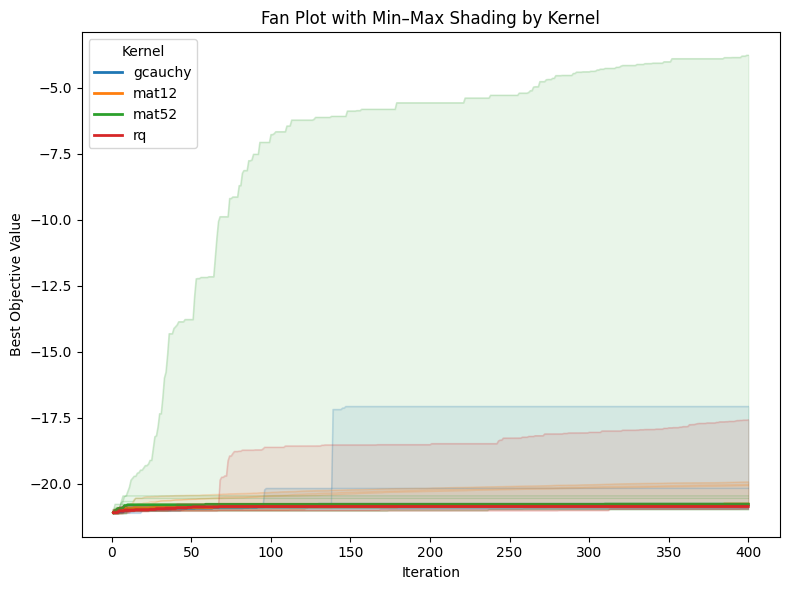

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

#res = pd.read_csv('rbrock50.csv')
#res = pd.read_csv('stybtang200.csv')
res.sort_values(['kernel','seed','iteration'], inplace=True)
res['best_obj'] = res.groupby(['kernel','seed'])['best_obj_val'].cummax()

kernels = res['kernel'].unique()
cmap    = get_cmap('tab10')
colors  = {k:cmap(i%10) for i,k in enumerate(kernels)}

fig,ax = plt.subplots(figsize=(8,6))
for k in kernels:
    dfk = res[res['kernel']==k]
    # plot each seed faintly
    for _,run in dfk.groupby('seed'):
        ax.plot(run.iteration, run.best_obj,
                color=colors[k], alpha=0.2, linewidth=1)
    # compute min, median, max across seeds at each iteration
    agg = ( dfk.groupby('iteration')['best_obj']
             .agg(['min','median','max']) )
    # shade between min and max
    ax.fill_between(agg.index, agg['min'], agg['max'],
                    color=colors[k], alpha=0.1)
    # plot median
    ax.plot(agg.index, agg['median'],
            color=colors[k], linewidth=2, label=str(k))

ax.set(xlabel='Iteration', ylabel='Best Objective Value',
       title='Fan Plot with Min–Max Shading by Kernel')
ax.legend(title='Kernel', loc='best')
plt.tight_layout()
plt.show()


/tmp/ipykernel_6744/1049993295.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap  = get_cmap('tab10')


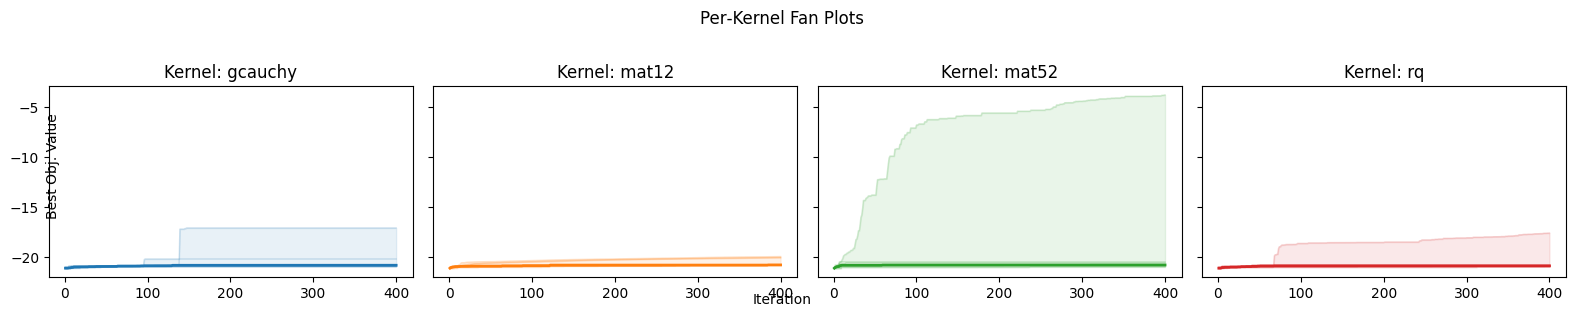

In [65]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# load & preprocess as before
#res = pd.read_csv('stybtang200.csv')
res.sort_values(['kernel','seed','iteration'], inplace=True)
res['best_obj'] = res.groupby(['kernel','seed'])['best_obj_val'].cummax()

# identify kernels & grid shape
kernels = sorted(res['kernel'].unique())
n_k = len(kernels)
ncols = 4                      # pick # columns you like
nrows = math.ceil(n_k / ncols)

# colormap
cmap  = get_cmap('tab10')
colors = {k: cmap(i % 10) for i,k in enumerate(kernels)}

# make subplots
fig, axes = plt.subplots(nrows, ncols,
                         sharex=True, sharey=True,
                         figsize=(4*ncols, 3*nrows))
axes = axes.flatten()

# loop kernels → each axis
for ax, k in zip(axes, kernels):
    dfk = res[res['kernel']==k]
    # faint individual runs
    for _, run in dfk.groupby('seed'):
        ax.plot(run.iteration, run.best_obj,
                color=colors[k], alpha=0.2, lw=1)
    # aggregate
    agg = dfk.groupby('iteration')['best_obj'].agg(['min','median','max'])
    # shade
    ax.fill_between(agg.index, agg['min'], agg['max'],
                    color=colors[k], alpha=0.1)
    # median line
    ax.plot(agg.index, agg['median'],
            color=colors[k], lw=2)
    ax.set_title(f'Kernel: {k}')

# turn off any empty subplots
for ax in axes[n_k:]:
    ax.axis('off')

# global labels
fig.text(0.5, 0.04, 'Iteration', ha='center')
fig.text(0.04, 0.5, 'Best Obj. Value', va='center', rotation='vertical')
fig.suptitle('Per‐Kernel Fan Plots', y=1.02)
plt.tight_layout()
plt.show()


# Violin Plot

/tmp/ipykernel_6744/1273585467.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap    = get_cmap('tab10')


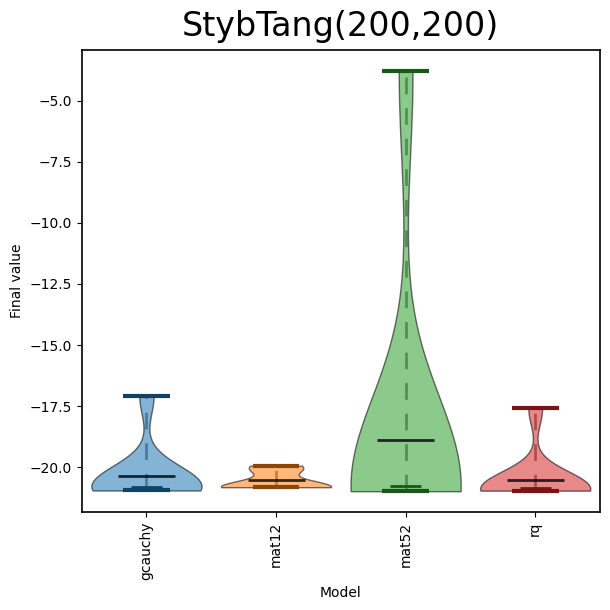

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import to_rgb

# --- data prep (same as you had) ---
# res = pd.read_csv('rbrock50.csv')
# res = pd.read_csv('stybtang200.csv')
res = res.sort_values(['kernel','seed','iteration']).copy()
res['best_obj'] = res.groupby(['kernel','seed'])['best_obj_val'].cummax()  # use cummin() if minimizing

# final (ultimate) value per run
final = (res.groupby(['kernel','seed'], sort=False)['best_obj']
           .last()
           .reset_index(name='final'))

kernels = final['kernel'].unique()
cmap    = get_cmap('tab10')
colors  = {k: cmap(i % 10) for i, k in enumerate(kernels)}

def darker(c, f=0.55):
    r,g,b = to_rgb(c)
    return (f*r, f*g, f*b)

# --- plotting ---
fig, ax = plt.subplots(figsize=(6.2,6.2))
positions = np.arange(1, len(kernels)+1)

# build violins without built-in stats marks (we'll draw them ourselves)
data = [final.loc[final.kernel==k, 'final'].values for k in kernels]
vp = ax.violinplot(data, positions=positions, widths=0.85,
                   showmeans=False, showmedians=False, showextrema=False)

# color each violin body
for body, k in zip(vp['bodies'], kernels):
    body.set_facecolor(colors[k])
    body.set_edgecolor('black')
    body.set_alpha(0.55)        # translucent fill
    body.set_linewidth(1.0)

# custom annotations per violin
for x, k in zip(positions, kernels):
    y = final.loc[final.kernel==k, 'final'].values
    if y.size == 0:
        continue
    y_min, y_max = float(np.min(y)), float(np.max(y))
    q1, q3 = np.percentile(y, [25, 75])
    y_med  = float(np.median(y))
    y_mean = float(np.mean(y))

    lc = darker(colors[k])      # line color (darker tone of the fill)
    cap_w  = 0.18               # half-width for cap ticks
    mean_w = 0.22               # half-width for mean bar
    med_w  = 0.12               # half-width for median bar

    # min→max centerline (dashed)
    ax.vlines(x, y_min, y_max, colors=lc, linestyles=(0, (6, 5)), linewidth=2, zorder=3, alpha=0.5)
    # caps at extrema
    ax.hlines([y_min, y_max], x-cap_w, x+cap_w, colors=lc, linewidth=3, zorder=4)
    # mean (black bar)
    ax.hlines(y_mean, x-mean_w, x+mean_w, colors='black', linewidth=2.0, zorder=5, alpha=0.8)
    # median (shorter bar, tone-matched)
    ax.hlines(y_med,  x-med_w,  x+med_w,  colors=lc, linewidth=2.0, zorder=5)

# axes/labels to match the look
ax.set_xticks(positions)
ax.set_xticklabels([str(k) for k in kernels], rotation = 90)
ax.set_xlabel('Model')
ax.set_ylabel('Final value')
ax.set_title(f'StybTang(200,200)', fontsize=24, pad=10)

ax.set_xlim(0.5, len(kernels)+0.5)
ax.grid(False)
for spine in ax.spines.values():
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()
